In [1]:
!pip install gradio xgboost
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.utils import resample


In [6]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('/content/7817_1 (1).csv')


Saving 7817_1.csv to 7817_1 (1).csv


In [7]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

df['reviews.text'] = df['reviews.text'].astype(str)
df['cleaned_review'] = df['reviews.text'].apply(preprocess)


In [8]:
def convert_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['reviews.rating'].apply(convert_sentiment)


In [9]:
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']
df_neutral = df[df['sentiment'] == 'neutral']

min_size = min(len(df_positive), len(df_negative), len(df_neutral))

df_balanced = pd.concat([
    resample(df_positive, replace=False, n_samples=min_size, random_state=42),
    resample(df_negative, replace=False, n_samples=min_size, random_state=42),
    resample(df_neutral, replace=False, n_samples=min_size, random_state=42)
])


In [10]:
tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X = tfidf.fit_transform(df_balanced['cleaned_review']).toarray()

le = LabelEncoder()
y = le.fit_transform(df_balanced['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Accuracy: 0.6521739130434783
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77        19
           1       0.86      0.38      0.52        16
           2       0.47      0.82      0.60        11

    accuracy                           0.65        46
   macro avg       0.69      0.66      0.63        46
weighted avg       0.72      0.65      0.64        46



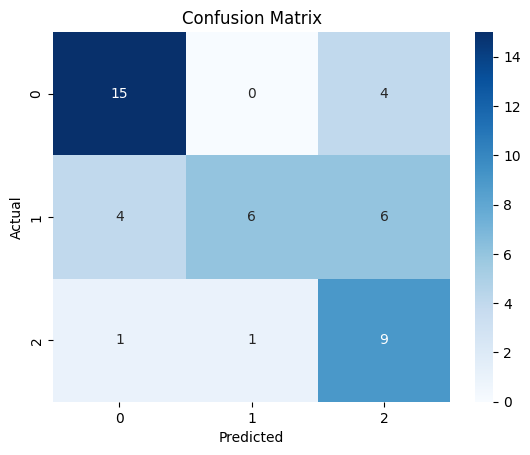

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
def predict_sentiment(text):
    cleaned = preprocess(text)
    vector = tfidf.transform([cleaned]).toarray()
    prediction = model.predict(vector)
    sentiment = le.inverse_transform(prediction)[0]
    return f"Predicted Sentiment: {sentiment.capitalize()}"

interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=4, placeholder="Enter a product review..."),
    outputs="text",
    title="Product Sentiment Predictor",
    description="This app predicts the sentiment (Positive, Neutral, Negative) of your product review."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f885f1be81bd516397.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Accuracy: 0.5375
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         7
           2       0.50      0.19      0.28        26
           3       0.00      0.00      0.00        59
           4       0.54      0.83      0.65       143
           5       0.54      0.60      0.57        81

    accuracy                           0.54       320
   macro avg       0.26      0.27      0.25       320
weighted avg       0.42      0.54      0.46       320



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


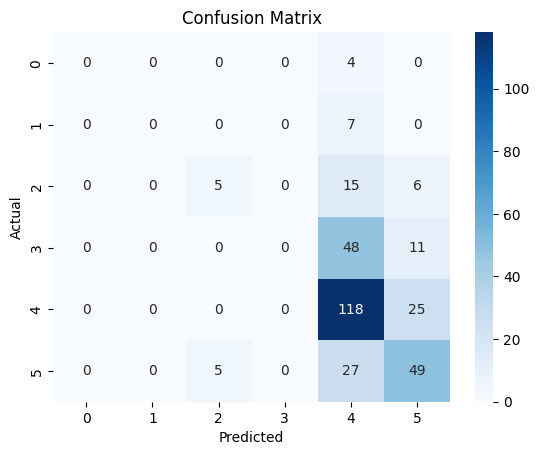

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#  Sample Input Code
sample_review = "The product is absolutely fantastic! Great quality and fast delivery."
sample_cleaned = preprocess(sample_review)
sample_vectorized = tfidf.transform([sample_cleaned]).toarray()
predicted_rating_encoded = model.predict(sample_vectorized)
predicted_rating = le.inverse_transform(predicted_rating_encoded)

print("Sample Review:", sample_review)
print("Predicted Rating:", predicted_rating[0])

Sample Review: The product is absolutely fantastic! Great quality and fast delivery.
Predicted Rating: 5.0


In [ ]:
#review as positive neutral or negative

def sentiment_analysis(rating):
  if rating > 3:
    return "Positive"
  elif rating < 3:
    return "Negative"
  else:
    return "Neutral"
print("Predicted Sentiment:", sentiment_analysis(predicted_rating[0]))

Predicted Sentiment: Positive


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr

def predict_sentiment(text):
    text = preprocess(text)
    vector = tfidf.transform([text]).toarray()
    prediction = model.predict(vector)
    return f"Predicted Rating: {le.inverse_transform(prediction)[0]}"

interface = gr.Interface(fn=predict_sentiment,
                         inputs="text",
                         outputs="text",
                         title="Product Review Rating Predictor",
                         description="Enter a product review to predict the rating.")

interface.launch(share=True)  # 'share=True' will give you a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf80df622568a2944f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
